# Assignment: Identify if a Cheque is Signed / Unsigned

This is my first attempt at working with image data. A cursory look reveals the following:
1. Images are positioned both horizontally and vertically.
2. Some of the images include irrelevant information in the form of large backgrounds.</b>

## Image Preprocessing

### Loading the required packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import glob

import cv2

import pandas as pd
import numpy as np
import random

### Loading the image data into lists
Two lists `signed` and `unsigned` are being created for each of the labels.<br>All further data prepocessing and manipulations will be applied similarly to both the lists.

### Rotating the image data
As the data is being loaded, they are also being rotated using a simple heuristic. If the height is larger than the width, then the image is rotated to make it horizontal. `HoughLines` and `Tesseract` operations were attempted, but with little success.<br><br>
<b>Limitations:</b><br>
1. Some of the images may have a very large background that takes up more space than the cheque. In this cases, the checque may already be horizontal and incorrectly rotated.
2. Some of the images may be rotated upside-down instead of upright as a result of a rule-based operation. <br><br>
<b>A sample image will be depicted after each manipulation</b>

In [2]:
signed = []
unsigned = []
for folder_path in glob.glob(r'''I:\Jupyter\Cheque\Signed\*'''):
    for img_path in glob.glob(folder_path + '\\*'):
        img = cv2.imread(img_path) #read the image
        if(img.shape[0] > img.shape[1]): #if height > width
            img = np.rot90(img) #rotate image
        signed.append(img)
        
for img_path in glob.glob(r'''I:\Jupyter\Cheque\Unsigned\\*'''):
    img = cv2.imread(img_path) #read image
    if(img.shape[0] > img.shape[1]): #if height > width
        img = np.rot90(img) #rotate image
    unsigned.append(img)
    
len(unsigned)
print("There are {} signed images and {} unsigned images. ".format(len(signed), len(unsigned)))

There are 102 signed images and 100 unsigned images. 


<b>For our purpose, the classes are balanced and we have an equal number of signed and unsigned images. </b>

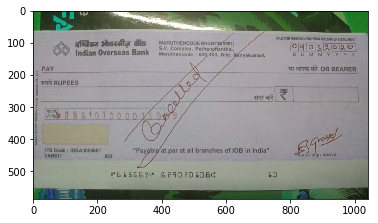

In [3]:
plt.imshow(signed[15])
plt.show()

### Converting Images into Grayscale
1. The images are being converted into grayscale as is required for some image manipulation algorithms that shall be further used such as canny edge detection.
2. **Since the signature on the cheques is mostly black or blue, the grayscale version of these images will be used as it reduces individual pixel data from a three-element tuple (R, G, B) into a single number.**

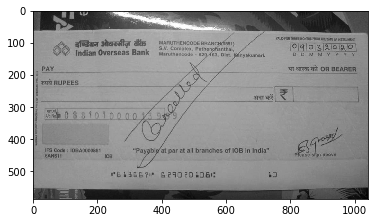

In [4]:
signed_gray   = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in signed]
unsigned_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in unsigned]

plt.imshow(signed_gray[15], cmap = "gray")
plt.show()

### Cropping Images
The images are being cropped using `Canny Edge Detection` in order to remove the irrelevant background and focus on the contents of the cheque. <br><br>
<b>Limitations:</b>
1. Some of the images may not be cropped sufficiently due to bold watermarks or edged objects in the background.
2. Some of the images may be over-cropped due to indistinguishable differences between the white cheque borders and the white background.

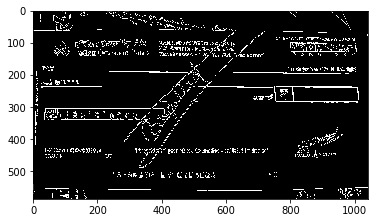

In [53]:
signed_canny   = [cv2.Canny(img_gray, 100, 150) for img_gray in signed] #detecting edges
unsigned_canny = [cv2.Canny(img_gray, 0, 200) for img_gray in signed]

plt.imshow(signed_canny[15], cmap = "gray")
plt.show()

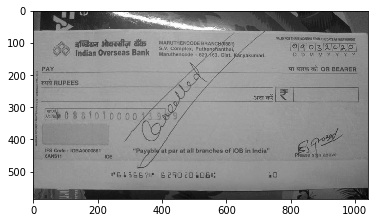

In [6]:
signed_cropped = []
for i in range(len(signed)):
    pts = np.argwhere(signed_canny[i] > 0) #all edge points
    y1, x1 = pts.min(axis = 0) #closest edge point to the origin
    y2, x2 = pts.max(axis = 0) #farthest edge points from the origin
    img_cropped = signed_gray[i][y1:y2, x1:x2] #crop using above edge points
    signed_cropped.append(img_cropped)
    
unsigned_cropped = []
for i in range(len(unsigned)):
    pts = np.argwhere(unsigned_canny[i] > 0) #all edge points
    y1, x1 = pts.min(axis = 0) #closest edge point to the origin
    y2, x2 = pts.max(axis = 0) #farthest edge points from the origin
    img_cropped = unsigned_gray[i][y1:y2, x1:x2] #crop using above edge points
    unsigned_cropped.append(img_cropped)
    

plt.imshow(signed_cropped[15], cmap = "gray")
plt.show()

### Exploratory Data Analysis
After cropping the images, we can take a look at some images that are wrongly (vertically) positioned.

In [7]:
vc = 0
verticals = []
for listicle in [signed_cropped, unsigned_cropped]:
    for i in range(len(listicle)):
        img = listicle[i]
        if(img.shape[0] > img.shape[1]):
            verticals.append(i)
            vc = vc + 1

print("There are {} images that are vertically positioned.".format(vc))

There are 3 images that are vertically positioned.


In [8]:
verticals

[18, 32, 70]

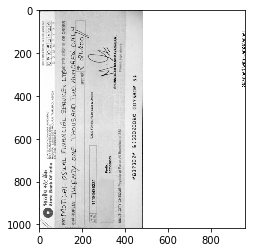

In [9]:
plt.imshow(signed_cropped[18], cmap="gray")
plt.show()

<b> In this image, the watermark at the bottom is considered as the edge. </b>

### Focus on ROI

The region of interest is the third quadrant, i.e. the bottom-right corner. The image is further halved vertically and horizontally and the third quadrant of the image is retained.

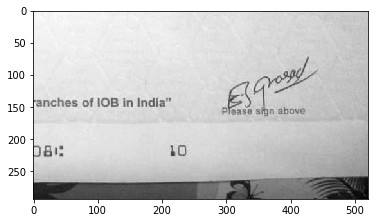

In [10]:
signed_roi = []
unsigned_roi = []

for i in range(len(signed_cropped)):
    img = signed_cropped[i]
    height = img.shape[0]
    width = img.shape[1]
    new_img = img[height//2:height, width//2:width] #cropping image to obtain the third quadrant
    signed_roi.append(new_img)

for i in range(len(unsigned_cropped)):
    img = unsigned_cropped[i]
    height = img.shape[0]
    width = img.shape[1]
    new_img = img[height//2:height, width//2:width] ##cropping image to obtain the third quadrant
    unsigned_roi.append(new_img)

plt.imshow(signed_roi[15], cmap = "gray")
plt.show()

### Image Resizing and Flattening
1. The images are being resized to 600 by 300 sq.pixels to maintain uniformity in the number of pixels in each image. This will be essential when a pixel-based dataframe is created.
2. The resized images are being flattened so that a single array contains all the pixels which allows us to input the image data into a dataframe easily.

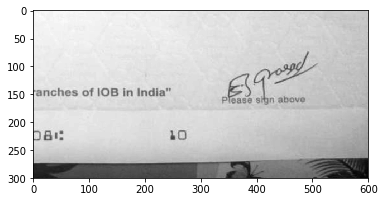

In [11]:
signed_resized = [cv2.resize(img, (600, 300)) for img in signed_roi] #resizing image
unsigned_resized = [cv2.resize(img, (600, 300)) for img in unsigned_roi]

plt.imshow(signed_resized[15], cmap = "gray")
plt.show()

In [12]:
signed_final = [img.flatten() for img in signed_resized] #flattening the arrays
unsigned_final = [img.flatten() for img in unsigned_resized]

### Creating a Dataframe
1. The pixels form the features in our dataset. There are 180000 pixels
2. A new column `Signed` forms our label wherein `value = 0` implies an unsigned image and `value = 1` implies a signed image.

In [13]:
df_signed = pd.DataFrame(signed_final)
df_signed.insert(0, 'Signed', 1)
df_signed.head()

,Signed,0,1,2,3,4,5,6,7,8,...,179990,179991,179992,179993,179994,179995,179996,179997,179998,179999
0,1,195,202,183,177,186,192,195,197,195,...,124,122,127,140,136,132,145,142,126,142
1,1,178,185,177,170,158,141,135,147,163,...,16,21,25,25,26,21,19,20,16,12
2,1,139,176,200,201,202,201,203,203,202,...,71,71,70,68,66,64,64,65,65,66
3,1,195,195,195,197,197,197,195,196,199,...,201,201,201,201,201,201,201,201,201,201
4,1,201,166,32,15,129,203,204,209,194,...,238,238,238,238,238,238,238,233,238,238


In [14]:
df_unsigned = pd.DataFrame(unsigned_final)
df_unsigned.insert(0, 'Signed', 0)
df_unsigned.head()

,Signed,0,1,2,3,4,5,6,7,8,...,179990,179991,179992,179993,179994,179995,179996,179997,179998,179999
0,0,74,96,134,170,168,166,165,168,178,...,10,9,9,10,11,12,11,10,9,8
1,0,174,167,165,170,174,174,174,176,180,...,255,255,255,255,255,255,255,255,255,255
2,0,171,170,169,170,172,173,173,172,167,...,215,216,220,220,220,219,217,218,220,223
3,0,153,153,153,153,153,153,153,153,153,...,208,209,210,210,210,210,210,209,208,208
4,0,159,159,159,159,158,158,157,157,157,...,162,162,162,162,162,163,163,163,163,164


In [15]:
df = df_signed.append(df_unsigned)
df.reset_index(inplace = True, drop = True)
df.head()

,Signed,0,1,2,3,4,5,6,7,8,...,179990,179991,179992,179993,179994,179995,179996,179997,179998,179999
0,1,195,202,183,177,186,192,195,197,195,...,124,122,127,140,136,132,145,142,126,142
1,1,178,185,177,170,158,141,135,147,163,...,16,21,25,25,26,21,19,20,16,12
2,1,139,176,200,201,202,201,203,203,202,...,71,71,70,68,66,64,64,65,65,66
3,1,195,195,195,197,197,197,195,196,199,...,201,201,201,201,201,201,201,201,201,201
4,1,201,166,32,15,129,203,204,209,194,...,238,238,238,238,238,238,238,233,238,238


In [16]:
df.tail()

,Signed,0,1,2,3,4,5,6,7,8,...,179990,179991,179992,179993,179994,179995,179996,179997,179998,179999
197,0,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
198,0,68,65,63,64,66,68,69,68,67,...,183,184,185,184,184,183,183,185,185,185
199,0,218,218,218,218,216,214,214,214,214,...,30,30,30,29,29,29,28,28,28,28
200,0,212,212,212,212,212,213,213,214,214,...,217,217,216,217,217,218,220,219,218,218
201,0,173,173,173,171,170,170,169,169,169,...,157,157,157,157,156,156,157,158,159,160


**Inspecting the dataframe**

In [17]:
df.shape

(202, 180001)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Columns: 180001 entries, Signed to 179999
dtypes: int64(180001)
memory usage: 277.4 MB


**Cross-checking that the range of the values is (0, 255) for the pixels**

In [19]:
round(df.iloc[:, :10].describe()).loc[['min', 'max']]

,Signed,0,1,2,3,4,5,6,7,8
min,0.0,2.0,16.0,32.0,15.0,6.0,0.0,4.0,32.0,67.0
max,1.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


## Modeling

### Train / Test Split

70% of the data is being used as the train set and 30% is being used as the test set.

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop('Signed', axis=1)
y = df['Signed']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

### Scaling

`StandardScaler()` is being used as PCA-transformations require normalized data, i.e. data with comparable variances. However in our case, as our features all fall in the range of (0, 255),`MinMaxScaler()` can also be considered.

In [21]:
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions

scaler = StandardScaler() #choose the scaler
scaler = scaler.fit(X_train) #fit the scaler to the train data

rescaled_X_train = scaler.transform(X_train) #rescale train data
rescaled_X_test = scaler.transform(X_test)   #rescale test data

set_printoptions(precision=3)
df_rescaled_X_train = pd.DataFrame(data = rescaled_X_train, columns = X.columns)
df_rescaled_X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,179990,179991,179992,179993,179994,179995,179996,179997,179998,179999
0,-0.097817,0.068875,-0.061118,-0.194806,-0.485956,-0.926314,-1.099715,-0.881536,-0.545157,-0.307159,...,-1.573819,-1.514315,-1.474893,-1.487454,-1.479068,-1.546489,-1.559009,-1.524566,-1.560807,-1.603437
1,1.626210,1.638836,1.602683,1.515633,1.528112,1.547036,1.555040,1.581588,1.609559,1.587773,...,1.416175,1.423895,1.439473,1.469232,1.452390,1.484955,1.479380,1.459240,1.528265,1.528571
2,0.103693,0.113731,0.152190,0.147282,0.116188,0.093401,0.072802,0.030732,0.016943,0.035298,...,0.716389,0.721279,0.720510,0.720377,0.726011,0.740161,0.749124,0.758694,0.765691,0.768125
3,0.372372,0.360439,0.365498,0.388755,0.427642,0.505626,0.537384,0.486866,0.461938,0.469078,...,0.767283,0.772379,0.771865,0.759111,0.764924,0.779361,0.788244,0.810587,0.817391,0.819681
4,0.820171,0.921139,1.453368,1.455264,0.905204,0.570714,0.891351,1.307908,1.305088,1.085501,...,0.449198,0.414683,0.412384,0.436329,0.466590,0.491896,0.475277,0.460314,0.455491,0.471680


### Feature Transformation - Principal Component Analysis
Since our dataset contains 180000 pixel-based features, PCA is a clear choice in this case. It reduces the dimensionality to a great extent, but along with it loses explainability. However, in our case, it is not necessary to know the exact pixels that are contributing to the end-result and thus, is an easy sacrifice to make.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95) #95% of the variance should be explained by the PCA-transformed features 
pca = pca.fit(rescaled_X_train) #fit to the scaled data

pca_X_train = pca.transform(rescaled_X_train) #pca-transform the scaled train data
pca_X_test  = pca.transform(rescaled_X_test)  #pca-transform the scaled test data

print("Original Shape: {}".format(rescaled_X_train.shape))
print("Transformed Shape: {}".format(pca_X_train.shape))
pca_no_of_features = pca_X_train.shape[1]

Original Shape: (141, 180000)
Transformed Shape: (141, 54)


In [23]:
pca_X_train

array([[ 2.313e+02, -4.452e+01,  1.509e+02, ...,  2.870e-01, -1.395e+01,
        -1.770e-01],
       [-5.690e+02, -1.080e+02, -4.141e+00, ...,  2.244e+00,  4.964e+00,
        -5.021e+00],
       [-7.929e+01,  9.381e+01, -1.066e+01, ..., -1.451e+01, -4.312e+01,
        -3.242e+00],
       ...,
       [ 7.441e+01,  6.051e+01, -1.284e+01, ...,  2.892e-01,  3.119e+01,
        -1.129e+00],
       [ 1.529e+02, -2.035e+02, -2.102e+01, ...,  1.614e+01, -5.655e+00,
        -1.437e+01],
       [-1.664e+02, -4.343e+00,  5.353e+01, ...,  9.121e+00,  1.530e+01,
        -1.447e+00]])

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver = "liblinear", verbose = 10) #choosing liblinear as the dataset is small

In [25]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, valid_scores = learning_curve(
#     LogisticRegression(solver = 'lbfgs'), X, y)

In [26]:
LR = LR.fit(pca_X_train, y_train) #fit the model to the train data

[LibLinear]

In [27]:
LR_y_train = LR.predict(pca_X_train) #predict for train data
LR_y_pred = LR.predict(pca_X_test) #predict for test data

#### Train Metrics for Logistic Regression

In [28]:
from sklearn import metrics
con_mat_train    = metrics.confusion_matrix(y_train, LR_y_train)
df_con_mat_train = pd.DataFrame(con_mat_train, index = ['Actual Negative','Actual Positive'], 
                                   columns = ['Predicted Negative','Predicted Positive'])
df_con_mat_train

,Predicted Negative,Predicted Positive
Actual Negative,57,10
Actual Positive,8,66


In [29]:
TP = con_mat_train[1,1] #true positive 
TN = con_mat_train[0,0] #true negative
FP = con_mat_train[0,1] #false positive
FN = con_mat_train[1,0] #false negative

Accuracy_LR_train = round(100*(metrics.accuracy_score(y_train, LR_y_train)),1)
Recall_LR_train= round(100*TP/float(TP+FN))
Specificity_LR_train = round(100*TN/float(TN+FP),1)
Precision_LR_train = round(100*TP/float(TP+FP))
FPR_LR_train = round(100*FP/float(TN+FP),1)

In [30]:
metrics = {'Accuracy': Accuracy_LR_train, 
           'Recall': Recall_LR_train,
           'Specificity': Specificity_LR_train,
           'Precision' : Precision_LR_train,
           'False Positive Rate': FPR_LR_train}
metrics

{'Accuracy': 87.2,
 'Recall': 89.0,
 'Specificity': 85.1,
 'Precision': 87.0,
 'False Positive Rate': 14.9}

#### Test Metrics for Logistic Regression

In [31]:
from sklearn import metrics
con_mat_test    = metrics.confusion_matrix(y_test, LR_y_pred)
df_con_mat_test = pd.DataFrame(con_mat_test, index = ['Actual Negative','Actual Positive'], 
                                   columns = ['Predicted Negative','Predicted Positive'])
df_con_mat_test

,Predicted Negative,Predicted Positive
Actual Negative,21,12
Actual Positive,8,20


In [32]:
TP = con_mat_test[1,1] #true positive 
TN = con_mat_test[0,0] #true negative
FP = con_mat_test[0,1] #false positive
FN = con_mat_test[1,0] #false negative

Accuracy_LR_test = round(100*(metrics.accuracy_score(y_test, LR_y_pred)),1)
Recall_LR_test = round(100*TP/float(TP+FN))
Specificity_LR_test = round(100*TN/float(TN+FP),1)
Precision_LR_test = round(100*TP/float(TP+FP))
FPR_LR_test = round(100*FP/float(TN+FP),1)

In [33]:
metrics = {'Accuracy': Accuracy_LR_test, 
           'Recall': Recall_LR_test,
           'Specificity': Specificity_LR_test,
           'Precision': Precision_LR_test,
           'False Positive Rate': FPR_LR_test}

metrics

{'Accuracy': 67.2,
 'Recall': 71.0,
 'Specificity': 63.6,
 'Precision': 62.0,
 'False Positive Rate': 36.4}

### Notes:
<b><ul>
 
<li>Logistic Regression seems to be us giving good starter results, although it is overfitting a bit as seen from the difference in train and test metrics.</li><br>

<li>This model performs best with <code>PCA (n_components = 0.95)</code> which gives us 54 features with 95% explainable variance.
    <ul><li>Variance > 95% results in more overfitting.</li>
        <li>Variance < 95% does not allow the model to capture the necessary data.</li></ul></li><br>
        
<li>The <code>liblinear</code> optimization algorithm has been chosen as it works well with small datasets and does not lead to convergence issues as with the default <code>lbfgs</code> solver.</li><br>

<li><code>Accuracy</code>can be used as the primary metric as the classes are balanced.
    <ul><li>However, if the purpose of the use case is detection fraudulent unsigned cheques, <code>Specificity</code> should be improved, and a precision score for negative predictions should be calculated.</li>
            <li>Similarly, if the purpose is detection of signed cheques, then the <code>Recall-Precision</code> metrics should be considered.</li></ul></li><br>

</ul></b>

## Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

num_trees = 100 #hyperparameter that chooses the number of features
max_features = pca_no_of_features #hyperparameter that chooses the number of features = number of features in the dataset

RF = RandomForestClassifier(n_estimators = num_trees, max_features = max_features) #call the model
RF = RF.fit(pca_X_train, y_train) #fit the model to the train data

RF_y_train = RF.predict(pca_X_train) #predict for train data
RF_y_pred = RF.predict(pca_X_test) #predict for test data

#### Train Metrics for Random Forest Classifier

In [35]:
from sklearn import metrics
con_mat_train    = metrics.confusion_matrix(y_train, RF_y_train)
df_con_mat_train = pd.DataFrame(con_mat_train, index = ['Actual Negative','Actual Positive'], 
                                columns = ['Predicted Negative','Predicted Positive'])
df_con_mat_train

,Predicted Negative,Predicted Positive
Actual Negative,67,0
Actual Positive,0,74


In [36]:
TP = con_mat_train[1,1] # true positive 
TN = con_mat_train[0,0] # true negative
FP = con_mat_train[0,1] # false positive
FN = con_mat_train[1,0] # false negative

Accuracy_RF_train = round(100*(metrics.accuracy_score(y_train, RF_y_train)),1)
Recall_RF_train = round(100*TP/float(TP+FN))
Specificity_RF_train = round(100*TN/float(TN+FP),1)
Precision_RF_train = round(100*TP/float(TP+FP))
FPR_RF_train = round(100*FP/float(TN+FP),1)

In [37]:
metrics = {'Accuracy': Accuracy_RF_train, 
           'Recall': Recall_RF_train,
           'Specificity': Specificity_RF_train,
           'Precision': Precision_RF_train,
           'False Positive Rate': FPR_RF_train}
metrics

{'Accuracy': 100.0,
 'Recall': 100.0,
 'Specificity': 100.0,
 'Precision': 100.0,
 'False Positive Rate': 0.0}

#### Test Metrics for Random Forest Classifier

In [38]:
from sklearn import metrics
con_mat_test = metrics.confusion_matrix(y_test, RF_y_pred)
df_con_mat_test = pd.DataFrame(con_mat_test, index = ['Actual Negative','Actual Positive'], 
                               columns = ['Predicted Negative','Predicted Positive'])
df_con_mat_test

,Predicted Negative,Predicted Positive
Actual Negative,20,13
Actual Positive,13,15


In [39]:
TP = con_mat_test[1,1] # true positive 
TN = con_mat_test[0,0] # true negative
FP = con_mat_test[0,1] # false positive
FN = con_mat_test[1,0] # false negative

Accuracy_RF_test = round(100*(metrics.accuracy_score(y_test, RF_y_pred)),1)
Recall_RF_test = round(100*TP/float(TP+FN))
Specificity_RF_test = round(100*TN/float(TN+FP),1)
Precision_RF_test = round(100*TP/float(TP+FP))
FPR_RF_test = round(100*FP/float(TN+FP),1)

In [40]:
metrics = {'Accuracy': Accuracy_RF_test, 
           'Recall': Recall_RF_test,
           'Specificity': Specificity_RF_test,
           'Precision': Precision_RF_test,
           'False Positive Rate': FPR_RF_test}
metrics

{'Accuracy': 57.4,
 'Recall': 54.0,
 'Specificity': 60.6,
 'Precision': 54.0,
 'False Positive Rate': 39.4}

### Notes:
<ul><b>

<li>The Random Forest model is severely overfitting and is unable to distinguish the nose in the data. The following iterations have shown no improvements.</li><ul>
    <li><code>PCA (0.85 < n_components < 0.99)</code> which results in features as less as 12 and as much as 107</li>
    <li> Reducing <code>max_features</code> to half of the number of features in the PCA-transformed dataset </li>

</ul><br>

</b>

### Further Iterations:
<b><ul>
    <li>The next iteration should focus on improving the edge-detection algorithm. The current edge-detection algorithm catches noise in the background, resulting in improper cropping of images, leaving images with irrelevant background information.<ul>
        <li>This offsets the pixel numbers corresponding the the cheque, affecting the values of the features used.</li>
        <li>The pixels capturing the background information creates unecessary noise in the features. </li></ul></li><br>
    <li> Since Logistic Regression did vastly better, other linear models such as SVC can be applied.</li><br>
    <li> Neural Networks such as a multi-layer net or a CNN can be applied. </li>